<Axes: xlabel='research_time', ylabel='premium'>

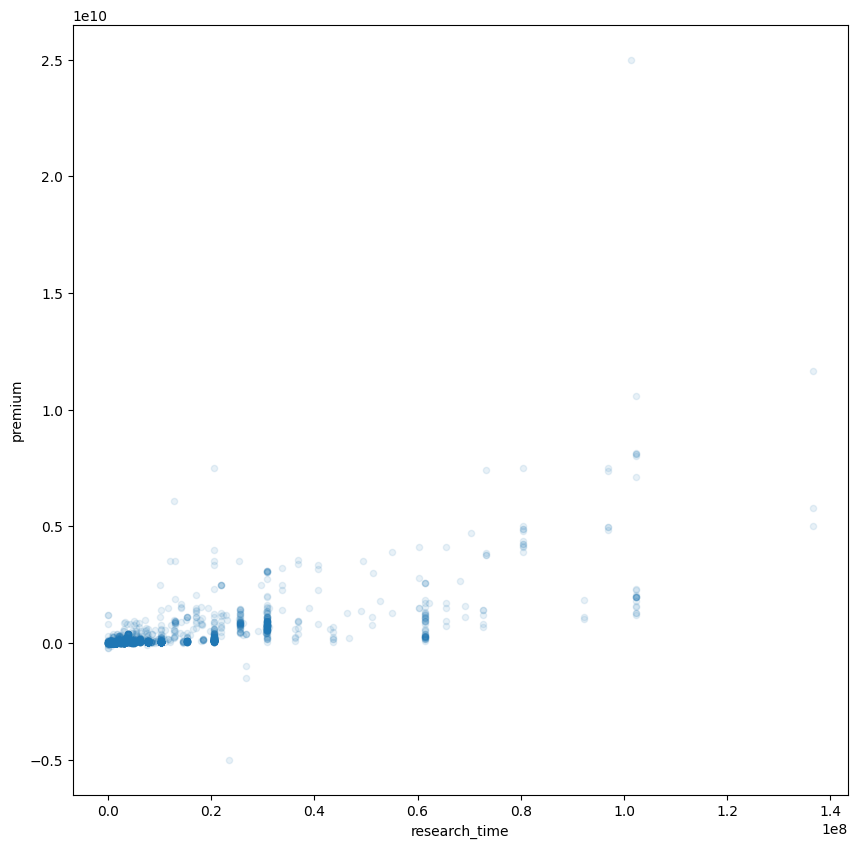

e:\Github\eve-api-db\venv\lib\site-packages\gevent\hub.py:161: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:


In [28]:
from src.util import connect_to_db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# level_modifiers = [x/105 for x in [0, 105, 250, 595, 1414, 3360, 8000, 19000, 45255, 107700, 256000]]
level_modifiers = {
    0: 0,
    1: 1/105,
    2: 250/105,
    3: 595/105,
    4: 1414/105,
    5: 3360/105,
    6: 8000/105,
    7: 19000/105,
    8: 45255/105,
    9: 107700/105,
    10: 256000/105    
}

def records_to_df(records):
    return pd.DataFrame([dict(r) for r in records])

conn = await connect_to_db()

contracts = records_to_df(await conn.fetch("SELECT * FROM esi.contracts"))
contract_items = records_to_df(await conn.fetch("SELECT * FROM esi.contract_items"))

type_ids = records_to_df(await conn.fetch("SELECT * FROM sde.type_ids"))

market_aggregates = records_to_df(await conn.fetch("SELECT * FROM market.aggregates WHERE location_id = 60003760"))
blueprints = records_to_df(await conn.fetch("SELECT * FROM sde.blueprints"))

contracts["count"] = contracts["contract_id"].map(contract_items.groupby("contract_id").size())
contracts = contracts[contracts["count"] == 1]

contracts = contracts.merge(contract_items, on="contract_id")

contracts = contracts[contracts["type"] == 'item_exchange']
contracts = contracts[contracts["is_included"]]
contracts = contracts[contracts["material_efficiency"].notna()]
contracts = contracts[~contracts["is_blueprint_copy"]]

contracts = contracts.merge(type_ids, left_on="type_id", right_on="type_id")
contracts = contracts.merge(blueprints, left_on="type_id", right_on="blueprint_type_id")

contracts["premium"] = (contracts["price"] - contracts["base_price"]).map(float)
contracts["pct_premium"] = (contracts["price"] / contracts["base_price"]).map(float)
contracts["research_time"] = contracts["time_efficiency"].map(lambda x: level_modifiers[int(x/2)]) * contracts["research_time_time"] \
    + contracts["material_efficiency"].map(lambda x: level_modifiers[int(x)]) * contracts["research_material_time"]

# contracts["research_time_premium"] = contracts["premium"].map(float) / contracts["research_time"]
# contracts = contracts[contracts["research_time_premium"].notna()]
# contracts = contracts[contracts["research_time_premium"] != float("-inf")]
# contracts = contracts[contracts["research_time_premium"] != float("inf")]

contracts[["contract_id", "type_id", "name", "base_price", "price", "premium", "is_blueprint_copy", "material_efficiency", "time_efficiency", "research_time"]].sort_values("research_time", ascending=True).head(30)


# contracts.plot(kind="scatter", x="research_time", y="premium", alpha=0.1, figsize=(10, 10), logx=True, logy=True)
contracts.plot(kind="scatter", x="research_time", y="premium", alpha=0.1, figsize=(10, 10))


<Axes: >

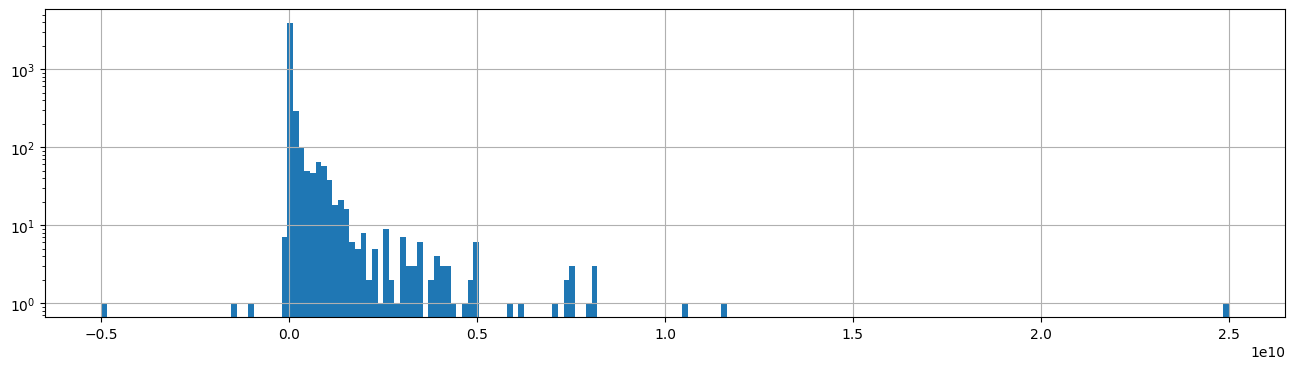

In [29]:
contracts["premium"].hist(bins=200, figsize=(16, 4), log=True)

<Axes: >

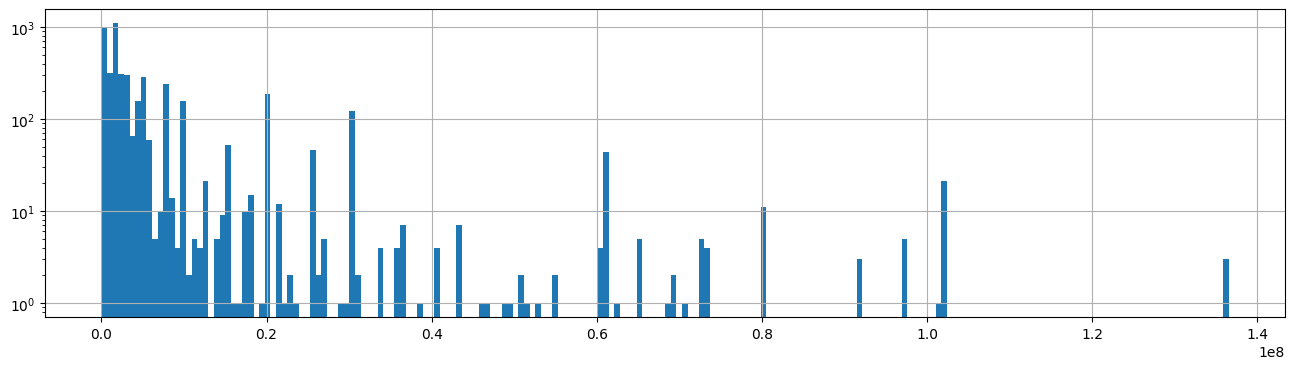

In [30]:
contracts["research_time"].hist(bins=200, figsize=(16, 4), log=True)

In [33]:
contracts[["contract_id", "name", "base_price", "price", "material_efficiency", "time_efficiency", "pct_premium"]].sort_values("pct_premium", ascending=True).head(40)

,contract_id,name,base_price,price,material_efficiency,time_efficiency,pct_premium
4421,199840365,Territorial Claim Unit Blueprint,250000000.00,150000000.00,7.0,14.0,0.600000
3966,200137854,Cynosural Field Generator I Blueprint,31372640.00,20000000.00,0.0,0.0,0.637498
4246,199530881,Standup L-Set EW Command System I Blueprint,500000000.00,400000000.00,0.0,0.0,0.800000
24,199796418,Prophecy Blueprint,555000000.00,480000000.00,0.0,0.0,0.864865
1458,200239829,Inferno Torpedo Blueprint,8000000.00,7000000.00,0.0,0.0,0.875000
1459,200239831,Inferno Torpedo Blueprint,8000000.00,7000000.00,0.0,0.0,0.875000
3447,200081918,Pirate Detection Array 4 Blueprint,1250000000.00,1100000000.00,5.0,0.0,0.880000
4476,200239825,Scourge Torpedo Blueprint,9000000.00,8000000.00,0.0,0.0,0.888889
4475,200239821,Scourge Torpedo Blueprint,9000000.00,8000000.00,0.0,0.0,0.888889
4676,200239795,Inferno XL Torpedo Blueprint,90000000.00,80000000.00,0.0,0.0,0.888889


e:\Github\eve-api-db\venv\lib\site-packages\gevent\hub.py:161: UserWarning: libuv only supports millisecond timer resolution; all times less will be set to 1 ms
  with loop.timer(seconds, ref=ref) as t:
